In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

/hdd/home/superdanby/.conda/envs/yee/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = '/hdd/dataset/tbrain/'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp_utf8.csv')
TS_IN=30
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
5228,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
7842,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9149,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
3921,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
10456,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11763,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0
2614,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
13070,6201,20130102,元大富櫃50,9.08,9.18,9.01,9.13,254.0
14377,6203,20130102,元大MSCI台灣,22.61,22.61,22.56,22.56,28.0


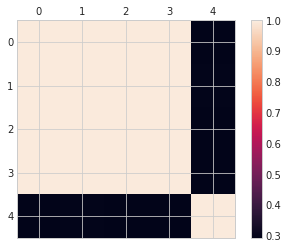

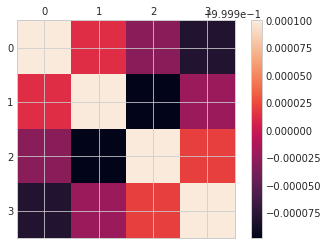

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[fields].corr())
fig.colorbar(cax)
plt.show()
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']].corr())
fig.colorbar(cax)
plt.show()

In [4]:
codes = list(sorted(set(train_csv['代碼'])))

Simple EDA on (code 50)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.00000,1307.000000
mean,62.089464,62.355142,61.806687,62.09798,9149.658761
std,10.785697,10.805576,10.763992,10.79194,7158.670288
min,45.970000,46.140000,45.670000,45.71000,809.000000
25%,53.670000,54.155000,53.520000,53.87000,4106.000000
50%,59.830000,60.070000,59.500000,59.81000,7088.000000
75%,68.500000,68.730000,68.330000,68.54000,11875.000000
max,85.840000,86.180000,85.690000,86.08000,61317.000000


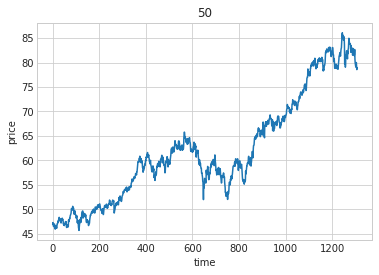

[[   83.8     84.1     83.6     83.85  4891.  ]
 [   84.      84.6     83.45    83.55  3429.  ]
 [   81.85    82.4     81.8     82.1   8259.  ]
 [   81.85    82.2     81.6     82.2   4369.  ]
 [   83.      83.4     82.95    83.4   3277.  ]
 [   82.9     82.9     82.2     82.25  4161.  ]
 [   82.25    82.35    81.8     82.1   4099.  ]
 [   82.65    83.05    82.65    82.85  4994.  ]
 [   82.85    83.05    82.75    82.95   878.  ]
 [   82.85    82.95    82.15    82.25  3737.  ]
 [   81.5     81.55    81.2     81.5   6187.  ]
 [   82.15    82.3     81.6     82.2   3401.  ]
 [   82.1     82.85    81.75    82.5   3860.  ]
 [   82.9     83.1     82.75    82.85  2603.  ]
 [   83.05    83.15    82.25    82.5   3591.  ]
 [   82.7     82.8     82.3     82.5   2982.  ]
 [   82.65    82.65    82.      82.3   1809.  ]
 [   82.4     82.4     81.35    81.4   4325.  ]
 [   81.6     82.1     81.35    81.6   3739.  ]
 [   81.9     82.65    81.9     82.65  4461.  ]
 [   81.      81.1     80.5     80.75  9

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,26.324805,26.437988,26.192119,26.300260,47.320581
std,2.684661,2.681309,2.687309,2.680824,76.016716
min,20.610000,21.170000,20.380000,20.380000,0.000000
25%,24.300000,24.360000,24.130000,24.235000,14.000000
50%,26.230000,26.330000,26.100000,26.220000,27.000000
75%,27.680000,27.785000,27.560000,27.600000,49.000000
max,33.150000,33.210000,33.020000,33.180000,1061.000000


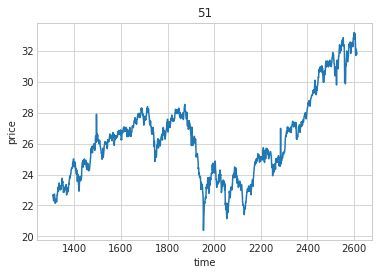

[[ 32.4   32.6   32.4   32.58  14.  ]
 [ 32.58  32.9   32.4   32.4   19.  ]
 [ 31.8   31.9   31.8   31.84  28.  ]
 [ 31.8   32.07  31.8   32.07   6.  ]
 [ 32.23  32.49  32.23  32.49  40.  ]
 [ 32.22  32.32  32.16  32.32  10.  ]
 [ 32.42  32.42  32.32  32.32   4.  ]
 [ 32.44  32.5   32.41  32.5    5.  ]
 [ 32.5   32.5   32.5   32.5    0.  ]
 [ 32.5   32.55  32.5   32.55   7.  ]
 [ 32.29  32.31  32.29  32.31   4.  ]
 [ 32.53  32.53  32.26  32.27  10.  ]
 [ 32.59  32.76  32.29  32.58 215.  ]
 [ 32.76  33.    32.72  32.86   6.  ]
 [ 32.66  32.9   32.66  32.9   18.  ]
 [ 33.    33.18  32.9   32.93 143.  ]
 [ 32.99  33.21  32.9   33.18  21.  ]
 [ 33.08  33.18  33.    33.    56.  ]
 [ 33.    33.    32.75  32.75   5.  ]
 [ 33.    33.15  32.98  33.15  12.  ]
 [ 33.15  33.15  33.02  33.02  13.  ]
 [ 33.02  33.02  33.    33.    34.  ]
 [ 32.6   32.6   32.44  32.44   9.  ]
 [ 32.02  32.02  32.02  32.02  11.  ]
 [ 32.06  32.15  31.71  31.71  21.  ]
 [ 31.91  32.11  31.65  32.11  12.  ]
 [ 31.72  32

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,37.169969,37.289112,37.024415,37.143183,13.850803
std,8.174995,8.194198,8.140942,8.167300,30.184653
min,25.970000,25.980000,25.970000,25.980000,0.000000
25%,31.035000,31.175000,30.720000,31.035000,2.000000
50%,35.490000,35.610000,35.240000,35.400000,5.000000
75%,41.115000,41.150000,40.965000,41.030000,12.000000
max,57.880000,58.070000,56.860000,57.540000,394.000000


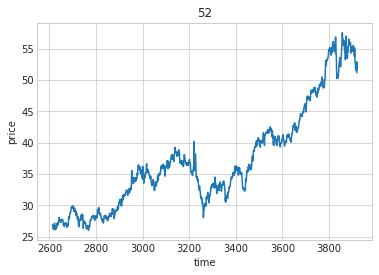

[[55.89 55.89 55.84 55.84  2.  ]
 [55.99 55.99 55.99 55.99  2.  ]
 [54.25 54.34 54.25 54.34  5.  ]
 [54.05 54.3  53.86 54.3   8.  ]
 [55.31 55.36 55.07 55.36  7.  ]
 [54.88 54.88 54.88 54.88  1.  ]
 [54.3  54.54 54.3  54.54  7.  ]
 [54.97 54.97 54.93 54.93  5.  ]
 [55.07 55.07 55.07 55.07  2.  ]
 [54.88 55.12 54.88 55.12  2.  ]
 [54.39 54.59 54.39 54.59  2.  ]
 [54.97 54.97 54.64 54.83 14.  ]
 [54.73 55.17 54.73 55.17  3.  ]
 [55.51 55.51 55.51 55.51  1.  ]
 [55.17 55.17 54.88 54.88  7.  ]
 [55.22 55.22 55.22 55.22  2.  ]
 [54.73 54.88 54.68 54.88 12.  ]
 [54.78 54.78 54.1  54.1   4.  ]
 [54.68 54.68 53.76 53.76  3.  ]
 [55.02 55.02 55.02 55.02  1.  ]
 [53.04 53.23 53.04 53.04  4.  ]
 [53.04 53.04 52.75 52.75  6.  ]
 [52.65 52.75 52.65 52.75  3.  ]
 [52.26 52.51 51.88 51.88  7.  ]
 [52.12 52.12 51.88 51.93 12.  ]
 [51.93 51.93 51.49 51.49  4.  ]
 [51.49 52.02 51.49 51.88  5.  ]
 [51.97 51.97 51.49 51.78 21.  ]
 [52.7  52.9  52.7  52.9   2.  ]
 [52.5  52.95 51.05 51.15 23.  ]]
Simple ED

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,26.710406,26.808768,26.595295,26.698646,38.573068
std,5.152289,5.142645,5.145575,5.134227,101.959206
min,19.140000,19.270000,18.140000,19.130000,0.000000
25%,23.040000,23.170000,22.935000,23.020000,8.000000
50%,25.800000,25.860000,25.640000,25.770000,17.000000
75%,29.255000,29.360000,29.155000,29.290000,42.000000
max,38.030000,38.030000,37.840000,37.860000,2866.000000


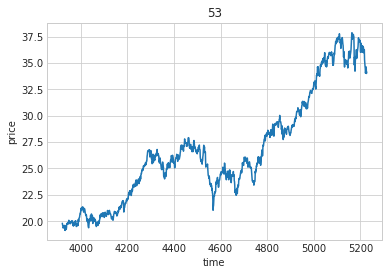

[[ 37.35  37.35  36.94  37.04  42.  ]
 [ 37.21  37.27  36.83  37.11  10.  ]
 [ 36.39  36.56  36.39  36.4    7.  ]
 [ 36.07  36.28  36.    36.    34.  ]
 [ 36.92  36.92  36.86  36.89   3.  ]
 [ 36.42  36.52  36.42  36.49   4.  ]
 [ 36.36  36.36  36.36  36.36   1.  ]
 [ 36.62  36.66  36.6   36.66   4.  ]
 [ 36.54  36.54  36.52  36.52   2.  ]
 [ 36.62  36.62  36.62  36.62   1.  ]
 [ 36.18  36.21  36.    36.     4.  ]
 [ 36.72  36.72  36.04  36.04  42.  ]
 [ 36.35  36.35  36.16  36.33   7.  ]
 [ 36.43  36.58  36.43  36.58   3.  ]
 [ 36.59  36.59  36.27  36.27   7.  ]
 [ 36.46  36.46  36.46  36.46   2.  ]
 [ 36.21  36.21  36.18  36.2    5.  ]
 [ 36.37  36.37  36.02  36.02   9.  ]
 [ 35.95  35.95  35.94  35.94   7.  ]
 [ 36.04  36.25  36.04  36.25  11.  ]
 [ 35.41  35.41  35.3   35.3   16.  ]
 [ 35.    35.    34.97  34.97  16.  ]
 [ 34.77  34.77  34.51  34.7   11.  ]
 [ 34.36  34.49  34.28  34.49  10.  ]
 [ 34.49  34.49  34.03  34.03  11.  ]
 [ 34.38  34.38  34.07  34.2    6.  ]
 [ 34.2   34

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,20.439893,20.511622,20.357353,20.438064,25.115532
std,2.355723,2.346377,2.368945,2.349442,42.828226
min,16.030000,16.140000,15.920000,16.100000,0.000000
25%,18.780000,18.840000,18.695000,18.770000,5.000000
50%,20.320000,20.420000,20.240000,20.320000,12.000000
75%,21.825000,21.900000,21.770000,21.840000,29.000000
max,25.490000,25.540000,25.420000,25.490000,568.000000


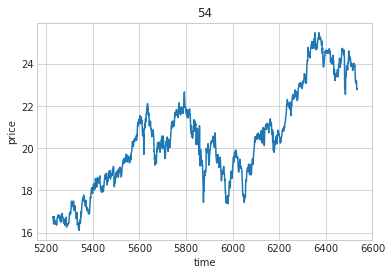

[[ 24.21  24.21  24.21  24.21   0.  ]
 [ 24.47  24.48  24.24  24.24  13.  ]
 [ 23.89  23.9   23.89  23.89  12.  ]
 [ 23.89  23.89  23.89  23.89   0.  ]
 [ 24.25  24.25  24.05  24.05   3.  ]
 [ 23.97  23.97  23.88  23.89 311.  ]
 [ 23.89  23.89  23.89  23.89   0.  ]
 [ 24.01  24.01  24.01  24.01  32.  ]
 [ 23.96  23.96  23.96  23.96   1.  ]
 [ 23.96  23.96  23.96  23.96   0.  ]
 [ 23.78  23.78  23.7   23.7    2.  ]
 [ 23.7   23.7   23.7   23.7    0.  ]
 [ 24.    24.    24.    24.     2.  ]
 [ 24.25  24.25  23.92  23.92   2.  ]
 [ 23.85  23.85  23.85  23.85   1.  ]
 [ 23.88  24.05  23.88  24.05   2.  ]
 [ 23.97  24.    23.92  24.     4.  ]
 [ 24.07  24.07  24.    24.     3.  ]
 [ 23.55  23.9   23.14  23.9   93.  ]
 [ 23.99  24.01  23.95  23.95  41.  ]
 [ 23.9   23.93  23.85  23.85  43.  ]
 [ 23.71  23.71  23.49  23.51  12.  ]
 [ 23.42  23.42  23.2   23.2   28.  ]
 [ 23.06  23.15  23.06  23.15  19.  ]
 [ 23.26  23.31  23.14  23.14  26.  ]
 [ 23.2   23.2   23.09  23.09   2.  ]
 [ 23.1   23

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,13.246014,13.308240,13.184981,13.246182,783.591431
std,1.712246,1.713001,1.708972,1.708292,1288.915204
min,9.820000,9.870000,9.760000,9.800000,2.000000
25%,11.920000,11.970000,11.875000,11.920000,122.500000
50%,13.120000,13.170000,13.060000,13.120000,370.000000
75%,14.485000,14.550000,14.460000,14.480000,929.500000
max,17.200000,17.220000,17.150000,17.200000,15113.000000


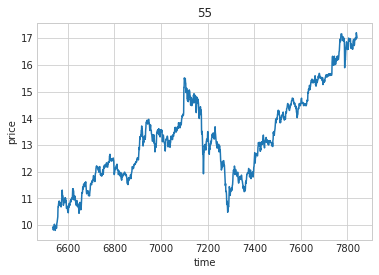

[[ 16.92  17.    16.92  16.95  43.  ]
 [ 16.95  16.98  16.86  16.95 326.  ]
 [ 16.84  16.84  16.65  16.65 119.  ]
 [ 16.65  16.65  16.62  16.62  27.  ]
 [ 16.79  16.94  16.78  16.78  45.  ]
 [ 16.8   16.8   16.7   16.75  17.  ]
 [ 16.75  16.75  16.58  16.61 125.  ]
 [ 16.61  16.72  16.61  16.69 419.  ]
 [ 16.66  16.72  16.66  16.7   38.  ]
 [ 16.7   16.7   16.69  16.69 125.  ]
 [ 16.71  16.71  16.56  16.58  67.  ]
 [ 16.61  16.66  16.61  16.66  28.  ]
 [ 16.67  16.88  16.67  16.88  34.  ]
 [ 16.95  16.97  16.9   16.92 119.  ]
 [ 16.96  16.97  16.92  16.95  29.  ]
 [ 17.01  17.01  16.92  16.93  12.  ]
 [ 16.93  16.93  16.87  16.87  45.  ]
 [ 16.92  16.92  16.71  16.72  29.  ]
 [ 16.85  16.85  16.75  16.76  15.  ]
 [ 16.82  16.93  16.82  16.93  70.  ]
 [ 16.9   16.95  16.88  16.95  67.  ]
 [ 16.96  17.    16.95  17.    65.  ]
 [ 17.03  17.03  16.95  16.99 120.  ]
 [ 16.99  16.99  16.9   16.94  69.  ]
 [ 16.99  16.99  16.94  16.96  26.  ]
 [ 17.02  17.04  17.    17.04  88.  ]
 [ 17.09  17

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,21.411064,21.484338,21.319587,21.408179,1927.348125
std,2.265922,2.268580,2.273911,2.271817,2072.866913
min,17.130000,17.200000,16.400000,17.050000,123.000000
25%,19.490000,19.555000,19.400000,19.510000,687.500000
50%,20.840000,20.900000,20.760000,20.840000,1252.000000
75%,22.860000,22.870000,22.755000,22.845000,2428.500000
max,26.760000,26.800000,26.570000,26.800000,18605.000000


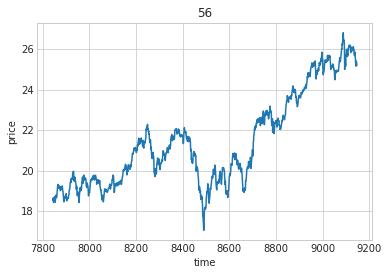

[[  26.13   26.25   26.13   26.17  698.  ]
 [  26.17   26.35   26.13   26.14 1536.  ]
 [  25.85   25.92   25.66   25.82 2810.  ]
 [  25.74   26.     25.73   26.    831.  ]
 [  26.06   26.14   26.06   26.08 1305.  ]
 [  26.05   26.06   25.92   25.93  714.  ]
 [  25.92   25.94   25.83   25.9  1355.  ]
 [  25.99   26.     25.9    25.96  509.  ]
 [  25.96   25.99   25.94   25.95  212.  ]
 [  25.99   26.06   25.98   26.02  633.  ]
 [  26.     26.     25.88   25.92  707.  ]
 [  25.95   25.96   25.85   25.95  795.  ]
 [  25.95   25.99   25.84   25.95  388.  ]
 [  26.01   26.12   26.     26.11 1469.  ]
 [  26.1    26.1    25.99   26.    303.  ]
 [  26.1    26.1    25.96   25.99  475.  ]
 [  26.04   26.04   25.77   25.98 1387.  ]
 [  25.96   25.96   25.6    25.77 2488.  ]
 [  25.77   25.81   25.65   25.68 1689.  ]
 [  25.7    25.88   25.7    25.86  699.  ]
 [  25.8    25.86   25.7    25.82  528.  ]
 [  25.82   25.82   25.65   25.69 1729.  ]
 [  25.81   25.81   25.35   25.5  4524.  ]
 [  25.45  

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,39.486297,39.570069,39.392892,39.479977,59.773527
std,5.899813,5.879175,5.904750,5.888137,141.309840
min,29.930000,29.960000,29.930000,29.960000,0.000000
25%,34.785000,34.830000,34.730000,34.790000,3.000000
50%,38.610000,38.740000,38.430000,38.580000,10.000000
75%,42.660000,42.725000,42.625000,42.635000,53.000000
max,52.900000,52.900000,52.900000,52.900000,1893.000000


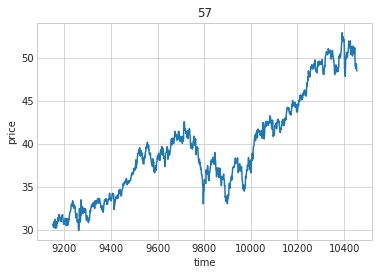

[[51.4  51.4  51.4  51.4   0.  ]
 [51.95 51.95 51.95 51.95  1.  ]
 [51.6  51.6  50.25 50.5  42.  ]
 [50.4  50.4  50.4  50.4   1.  ]
 [51.35 51.35 50.95 51.05 25.  ]
 [51.   51.   50.9  50.9   2.  ]
 [50.55 50.55 50.55 50.55  2.  ]
 [51.3  51.3  51.3  51.3   1.  ]
 [51.3  51.3  51.3  51.3   1.  ]
 [51.3  51.3  51.3  51.3   0.  ]
 [50.25 50.25 50.2  50.2   2.  ]
 [50.65 50.65 50.4  50.5  22.  ]
 [50.65 50.85 50.65 50.85  5.  ]
 [51.35 51.35 51.35 51.35  1.  ]
 [51.2  51.25 51.2  51.2   3.  ]
 [51.15 51.2  51.15 51.2   2.  ]
 [50.95 50.95 50.9  50.9   2.  ]
 [50.85 50.85 50.85 50.85  5.  ]
 [50.5  50.5  50.45 50.45  9.  ]
 [50.9  51.15 50.9  51.15  2.  ]
 [51.15 51.15 51.15 51.15  0.  ]
 [49.59 49.68 49.59 49.63  3.  ]
 [49.26 49.26 48.75 48.94  5.  ]
 [48.94 48.94 48.94 48.94  0.  ]
 [48.91 48.91 48.91 48.91  2.  ]
 [48.86 48.86 48.44 48.74  6.  ]
 [48.85 49.31 48.85 49.31  2.  ]
 [49.05 49.34 49.05 49.26  4.  ]
 [48.61 48.61 48.31 48.55  9.  ]
 [48.52 48.52 48.46 48.46  2.  ]]
Simple ED

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,38.543397,38.586526,38.494675,38.538018,7.361132
std,4.598829,4.595955,4.597551,4.591754,20.575405
min,30.630000,30.750000,30.630000,30.750000,0.000000
25%,35.095000,35.110000,35.030000,35.090000,0.000000
50%,37.740000,37.830000,37.730000,37.770000,2.000000
75%,40.510000,40.565000,40.440000,40.530000,5.000000
max,48.730000,48.900000,48.730000,48.800000,426.000000


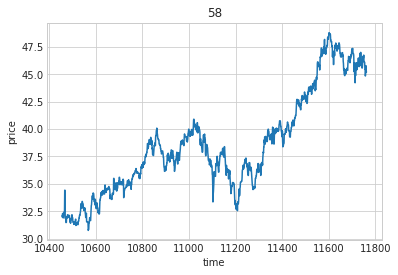

[[46.52 46.52 46.52 46.52  0.  ]
 [46.92 46.92 46.92 46.92  1.  ]
 [45.95 46.2  45.95 46.2   3.  ]
 [46.   46.   45.8  45.8   2.  ]
 [46.5  47.01 46.5  47.01  3.  ]
 [46.77 46.77 46.19 46.19  2.  ]
 [46.19 46.19 46.19 46.19  0.  ]
 [46.19 46.19 46.19 46.19  0.  ]
 [46.25 46.25 46.25 46.25  0.  ]
 [45.88 45.88 45.88 45.88 10.  ]
 [45.51 45.57 45.51 45.57  2.  ]
 [45.69 45.69 45.62 45.62  2.  ]
 [45.87 46.12 45.87 45.98  4.  ]
 [46.64 46.64 46.64 46.64  1.  ]
 [46.55 46.55 46.26 46.26  2.  ]
 [46.49 46.49 46.49 46.49  1.  ]
 [46.49 46.49 46.49 46.49  0.  ]
 [46.75 46.76 46.75 46.76  2.  ]
 [46.32 46.32 46.16 46.16  9.  ]
 [46.16 46.16 46.16 46.16  0.  ]
 [46.44 46.44 46.1  46.1  22.  ]
 [46.1  46.1  46.1  46.1   0.  ]
 [45.43 45.46 45.43 45.46  2.  ]
 [45.46 45.46 45.46 45.46  0.  ]
 [44.85 44.85 44.85 44.85  0.  ]
 [45.06 45.06 45.06 45.06  3.  ]
 [45.45 45.45 45.45 45.45  1.  ]
 [45.61 45.78 45.61 45.78  2.  ]
 [45.53 45.53 45.23 45.24  4.  ]
 [45.22 45.22 45.22 45.22  1.  ]]
Simple ED

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,32.767322,32.857490,32.669579,32.754185,13.521806
std,4.030443,4.053468,4.002721,4.014035,33.348502
min,24.360000,24.400000,24.360000,24.360000,0.000000
25%,29.740000,29.770000,29.695000,29.730000,2.000000
50%,32.590000,32.680000,32.530000,32.580000,4.000000
75%,35.190000,35.295000,35.080000,35.180000,12.000000
max,42.500000,42.500000,42.390000,42.500000,504.000000


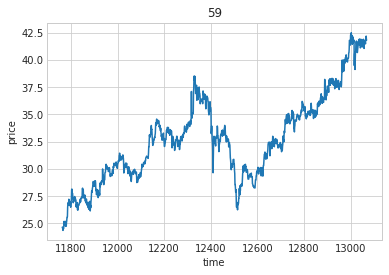

[[41.61 41.61 41.36 41.36  7.  ]
 [41.8  41.87 41.53 41.53  3.  ]
 [41.11 41.31 41.11 41.11  4.  ]
 [41.19 41.19 41.19 41.19  1.  ]
 [41.81 41.92 41.81 41.91  4.  ]
 [41.76 41.76 41.76 41.76  1.  ]
 [41.76 41.76 41.76 41.76  0.  ]
 [41.72 41.72 41.72 41.72  1.  ]
 [41.72 41.72 41.72 41.72  0.  ]
 [41.63 41.63 41.63 41.63  2.  ]
 [41.19 41.19 41.19 41.19  4.  ]
 [41.28 41.28 41.28 41.28  1.  ]
 [41.41 41.49 41.3  41.49  5.  ]
 [41.91 41.91 41.86 41.86  2.  ]
 [41.86 41.86 41.86 41.86  0.  ]
 [41.9  41.9  41.9  41.9   1.  ]
 [41.7  41.7  41.7  41.7   1.  ]
 [41.63 41.63 41.54 41.54  5.  ]
 [41.26 41.26 41.06 41.06 11.  ]
 [41.3  41.79 41.3  41.79  6.  ]
 [41.79 41.79 41.79 41.79  0.  ]
 [41.76 41.76 41.56 41.56 51.  ]
 [41.73 41.73 41.7  41.7   2.  ]
 [41.58 41.58 41.58 41.58  1.  ]
 [41.52 41.52 41.48 41.48  3.  ]
 [42.   42.   41.97 41.97  3.  ]
 [42.1  42.1  42.   42.    2.  ]
 [42.   42.19 42.   42.19  2.  ]
 [42.1  42.1  41.86 41.86  4.  ]
 [41.83 41.83 41.83 41.83  1.  ]]
Simple ED

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,269.000000,269.000000,269.000000,269.000000,269.000000
mean,20.824572,20.880446,20.752528,20.818030,694.892193
std,0.970134,0.978990,0.950231,0.961581,386.353464
min,18.720000,18.800000,18.710000,18.780000,20.000000
25%,20.180000,20.280000,20.140000,20.240000,517.000000
50%,20.850000,20.920000,20.790000,20.830000,666.000000
75%,21.650000,21.680000,21.480000,21.540000,864.000000
max,22.520000,22.540000,22.400000,22.480000,2891.000000


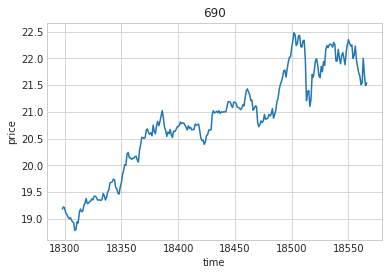

[[ 22.25  22.35  22.23  22.3  500.  ]
 [ 22.3   22.45  22.16  22.26 704.  ]
 [ 22.15  22.15  21.86  21.95 501.  ]
 [ 21.95  22.    21.89  21.95 454.  ]
 [ 22.16  22.19  22.09  22.17 744.  ]
 [ 22.17  22.17  21.99  22.01  53.  ]
 [ 22.01  22.01  21.9   21.9  424.  ]
 [ 21.95  22.15  21.95  22.05  51.  ]
 [ 22.05  22.15  22.05  22.11  38.  ]
 [ 22.15  22.18  22.    22.   524.  ]
 [ 21.94  21.94  21.83  21.88 540.  ]
 [ 22.02  22.14  21.97  22.13 397.  ]
 [ 22.18  22.3   22.1   22.26 335.  ]
 [ 22.3   22.4   22.3   22.35 363.  ]
 [ 22.35  22.4   22.16  22.28 312.  ]
 [ 22.35  22.35  22.2   22.23 279.  ]
 [ 22.2   22.25  22.17  22.25 262.  ]
 [ 22.25  22.25  21.98  22.   311.  ]
 [ 22.1   22.19  22.    22.06  26.  ]
 [ 22.12  22.25  22.12  22.23 420.  ]
 [ 22.    22.05  21.93  21.97 350.  ]
 [ 21.91  21.95  21.84  21.84 377.  ]
 [ 21.84  21.84  21.61  21.73 398.  ]
 [ 21.73  21.73  21.55  21.67 202.  ]
 [ 21.65  21.7   21.36  21.51 949.  ]
 [ 21.51  21.66  21.51  21.54 281.  ]
 [ 21.68  22

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,239.000000,239.000000,239.000000,239.000000,239.000000
mean,20.658201,20.718285,20.583975,20.657992,1369.635983
std,0.821163,0.824610,0.797484,0.810186,1225.970830
min,18.750000,18.810000,18.660000,18.780000,411.000000
25%,20.210000,20.255000,20.155000,20.210000,883.500000
50%,20.680000,20.750000,20.600000,20.700000,1084.000000
75%,21.295000,21.350000,21.140000,21.250000,1419.500000
max,22.200000,22.290000,22.150000,22.250000,14039.000000


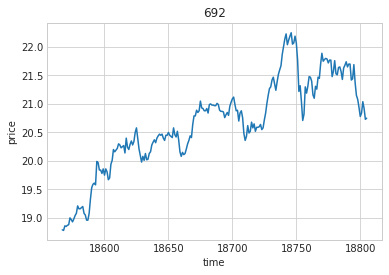

[[  21.8    21.83   21.72   21.77  613.  ]
 [  21.83   21.94   21.7    21.77  655.  ]
 [  21.5    21.51   21.35   21.48  903.  ]
 [  21.24   21.57   21.24   21.57  756.  ]
 [  21.57   21.76   21.57   21.76  674.  ]
 [  21.74   21.74   21.53   21.53  620.  ]
 [  21.52   21.53   21.41   21.51  586.  ]
 [  21.53   21.67   21.53   21.64  569.  ]
 [  21.65   21.65   21.63   21.65  511.  ]
 [  21.65   21.68   21.56   21.57  570.  ]
 [  21.67   21.67   21.34   21.43  654.  ]
 [  21.63   21.66   21.49   21.63  660.  ]
 [  21.6    21.73   21.51   21.68  537.  ]
 [  21.68   21.77   21.68   21.74  563.  ]
 [  21.74   21.8    21.63   21.65  607.  ]
 [  21.67   21.7    21.62   21.7   531.  ]
 [  21.66   21.7    21.59   21.7   710.  ]
 [  21.7    21.7    21.4    21.42  876.  ]
 [  21.42   21.53   21.4    21.44  541.  ]
 [  21.5    21.7    21.5    21.69  831.  ]
 [  21.6    21.6    21.33   21.37 1093.  ]
 [  21.3    21.3    21.14   21.15 1358.  ]
 [  21.27   21.27   20.93   21.08 1362.  ]
 [  20.95  

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,174.000000,174.000000,174.000000,174.000000,174.000000
mean,20.525862,20.580172,20.441667,20.505172,517.436782
std,0.542831,0.547172,0.497365,0.506267,1446.224770
min,19.700000,19.720000,19.630000,19.670000,4.000000
25%,20.050000,20.122500,20.000000,20.072500,62.750000
50%,20.335000,20.405000,20.290000,20.330000,143.500000
75%,20.937500,21.022500,20.897500,20.937500,420.250000
max,22.500000,22.500000,21.480000,21.500000,13660.000000


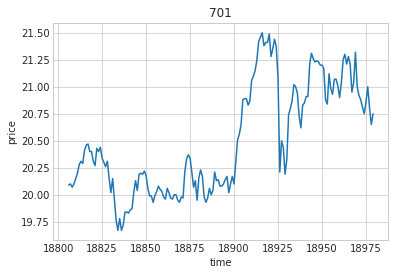

[[ 21.24  21.26  21.19  21.2   65.  ]
 [ 21.27  21.38  21.17  21.17  42.  ]
 [ 20.92  20.96  20.88  20.88  57.  ]
 [ 20.88  20.88  20.81  20.84 117.  ]
 [ 20.88  21.12  20.88  21.12  79.  ]
 [ 21.06  21.06  20.97  20.98  30.  ]
 [ 20.94  20.96  20.9   20.93  38.  ]
 [ 21.03  21.07  21.02  21.07 125.  ]
 [ 21.04  21.07  21.04  21.07   8.  ]
 [ 21.07  21.07  21.    21.01  20.  ]
 [ 20.92  20.92  20.85  20.9   29.  ]
 [ 22.5   22.5   20.98  21.04  75.  ]
 [ 21.03  21.29  21.03  21.25  60.  ]
 [ 21.23  21.33  21.23  21.3   54.  ]
 [ 21.29  21.34  21.21  21.21  20.  ]
 [ 21.26  21.28  21.21  21.28  23.  ]
 [ 21.28  21.28  21.18  21.21  33.  ]
 [ 21.16  21.21  20.95  20.95  49.  ]
 [ 21.    21.1   21.    21.04  38.  ]
 [ 21.11  21.32  21.11  21.32  91.  ]
 [ 21.02  21.04  20.99  21.    45.  ]
 [ 20.96  20.96  20.9   20.92  47.  ]
 [ 20.9   20.9   20.83  20.88  38.  ]
 [ 20.81  20.81  20.73  20.81  19.  ]
 [ 20.88  20.88  20.75  20.75  34.  ]
 [ 20.91  20.91  20.84  20.86  17.  ]
 [ 20.86  21

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,145.000000,145.000000,145.000000,145.000000,145.000000
mean,30.583862,30.661034,30.473724,30.563379,567.524138
std,0.390015,0.358670,0.396519,0.364042,1131.224988
min,29.230000,29.900000,29.230000,29.790000,2.000000
25%,30.330000,30.440000,30.190000,30.300000,24.000000
50%,30.640000,30.690000,30.570000,30.610000,80.000000
75%,30.840000,30.920000,30.740000,30.840000,346.000000
max,31.500000,31.500000,31.270000,31.300000,5432.000000


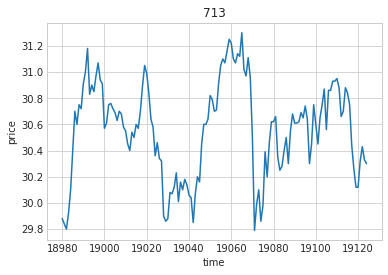

[[3.077e+01 3.082e+01 3.074e+01 3.074e+01 3.345e+03]
 [3.083e+01 3.092e+01 3.061e+01 3.064e+01 3.305e+03]
 [3.064e+01 3.064e+01 3.027e+01 3.030e+01 9.000e+01]
 [2.923e+01 3.045e+01 2.923e+01 3.045e+01 8.800e+01]
 [3.045e+01 3.075e+01 3.012e+01 3.075e+01 1.100e+01]
 [3.065e+01 3.065e+01 3.051e+01 3.060e+01 1.000e+01]
 [3.042e+01 3.059e+01 3.042e+01 3.045e+01 1.100e+01]
 [3.069e+01 3.069e+01 3.065e+01 3.065e+01 2.000e+00]
 [3.070e+01 3.075e+01 3.070e+01 3.075e+01 1.400e+01]
 [3.085e+01 3.091e+01 3.080e+01 3.087e+01 6.400e+01]
 [2.997e+01 3.066e+01 2.997e+01 3.056e+01 1.900e+01]
 [3.073e+01 3.086e+01 3.073e+01 3.086e+01 2.700e+01]
 [3.087e+01 3.094e+01 3.083e+01 3.086e+01 2.500e+01]
 [3.097e+01 3.100e+01 3.093e+01 3.093e+01 1.900e+01]
 [3.100e+01 3.100e+01 3.093e+01 3.093e+01 4.000e+00]
 [3.101e+01 3.108e+01 3.092e+01 3.095e+01 3.400e+01]
 [3.095e+01 3.095e+01 3.083e+01 3.088e+01 8.000e+00]
 [3.103e+01 3.103e+01 3.066e+01 3.066e+01 8.000e+00]
 [3.070e+01 3.070e+01 3.070e+01 3.070e+01 4.00

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,11.472318,11.533581,11.397536,11.459518,75.377965
std,1.347550,1.351618,1.340661,1.341919,116.025830
min,8.690000,9.070000,8.630000,8.640000,0.000000
25%,10.600000,10.660000,10.530000,10.580000,23.000000
50%,11.130000,11.160000,11.030000,11.090000,46.000000
75%,12.040000,12.095000,11.980000,12.030000,89.000000
max,16.220000,16.220000,15.040000,15.150000,1602.000000


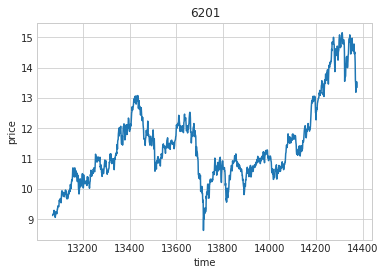

[[ 15.    15.    14.9   14.93  50.  ]
 [ 15.01  15.01  14.85  14.85  46.  ]
 [ 14.47  14.54  14.42  14.45  83.  ]
 [ 14.16  14.58  14.16  14.54 103.  ]
 [ 14.77  14.88  14.77  14.77  12.  ]
 [ 14.77  14.77  14.62  14.62 346.  ]
 [ 14.8   14.8   14.67  14.75  45.  ]
 [ 16.22  16.22  14.9   14.95  36.  ]
 [ 15.01  15.01  14.96  14.97  47.  ]
 [ 14.87  14.87  14.72  14.72  36.  ]
 [ 14.59  14.59  14.56  14.56  26.  ]
 [ 14.6   14.69  14.52  14.56  31.  ]
 [ 14.63  14.63  14.57  14.57 152.  ]
 [ 14.56  14.69  14.56  14.62 176.  ]
 [ 14.6   14.61  14.53  14.55  44.  ]
 [ 14.68  14.71  14.67  14.69  17.  ]
 [ 14.72  14.78  14.7   14.78 226.  ]
 [ 14.75  14.75  14.5   14.5   50.  ]
 [ 14.5   14.56  14.36  14.45 118.  ]
 [ 14.46  14.62  14.46  14.52  41.  ]
 [ 14.55  14.55  14.41  14.41  87.  ]
 [ 14.48  14.48  14.12  14.16 188.  ]
 [ 13.95  13.95  13.44  13.59 183.  ]
 [ 13.59  13.59  13.34  13.5   93.  ]
 [ 13.51  13.6   13.16  13.19  67.  ]
 [ 13.19  13.41  13.19  13.26  18.  ]
 [ 13.56  13

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,29.519319,29.581844,29.457246,29.523152,242.397093
std,4.619262,4.606099,4.628229,4.614499,8024.657577
min,22.300000,22.300000,22.300000,22.300000,0.000000
25%,26.045000,26.180000,25.855000,26.060000,1.000000
50%,28.760000,28.860000,28.600000,28.730000,3.000000
75%,31.930000,31.935000,31.925000,31.930000,15.000000
max,40.200000,40.200000,40.030000,40.030000,290124.000000


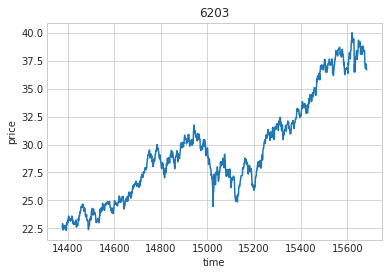

[[39.26 39.26 39.1  39.1  12.  ]
 [39.2  39.2  39.2  39.2   1.  ]
 [39.2  39.2  39.2  39.2   0.  ]
 [38.07 38.09 38.07 38.09  3.  ]
 [38.84 38.84 38.78 38.78  2.  ]
 [38.78 38.78 38.78 38.78  0.  ]
 [38.4  38.4  38.4  38.4   0.  ]
 [38.35 38.35 38.35 38.35  0.  ]
 [38.48 38.5  38.48 38.5   2.  ]
 [38.6  38.6  38.6  38.6   1.  ]
 [38.1  38.16 38.1  38.1   3.  ]
 [38.16 38.22 38.16 38.22  2.  ]
 [38.59 38.59 38.59 38.59  1.  ]
 [38.85 38.85 38.83 38.83  4.  ]
 [38.83 38.83 38.83 38.83  0.  ]
 [38.75 38.75 38.75 38.75  1.  ]
 [38.4  38.4  38.4  38.4   1.  ]
 [38.36 38.36 38.36 38.36  1.  ]
 [38.36 38.36 38.36 38.36  0.  ]
 [37.84 38.42 37.84 38.42 82.  ]
 [38.42 38.42 38.42 38.42  0.  ]
 [37.37 37.37 37.37 37.37  2.  ]
 [37.09 37.09 37.08 37.08 20.  ]
 [36.96 36.96 36.94 36.94  3.  ]
 [37.05 37.05 36.81 36.81  7.  ]
 [36.82 36.82 36.82 36.82  1.  ]
 [36.91 37.24 36.91 37.24 13.  ]
 [37.29 37.41 37.18 37.18  6.  ]
 [36.95 36.95 36.64 36.82 78.  ]
 [36.72 36.72 36.7  36.7   3.  ]]
Simple ED

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,42.386052,42.461890,42.297314,42.382028,193.449120
std,5.805375,5.771369,5.844431,5.806056,520.229453
min,33.320000,33.430000,33.000000,33.050000,0.000000
25%,38.045000,38.190000,37.925000,38.055000,2.000000
50%,41.160000,41.240000,40.990000,41.110000,9.000000
75%,44.780000,44.870000,44.780000,44.780000,152.500000
max,55.700000,55.750000,55.700000,55.700000,7868.000000


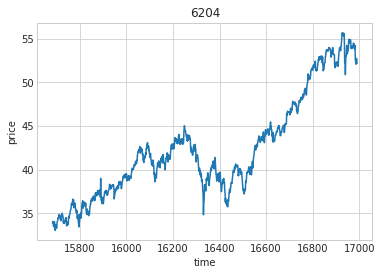

[[54.95 54.95 54.8  54.9  27.  ]
 [54.9  54.9  54.9  54.9   0.  ]
 [54.75 54.75 54.75 54.75  0.  ]
 [53.9  53.9  53.9  53.9   0.  ]
 [53.9  53.9  53.9  53.9   0.  ]
 [54.05 54.05 54.05 54.05  1.  ]
 [54.05 54.05 54.05 54.05  0.  ]
 [53.9  53.9  53.9  53.9   0.  ]
 [54.3  54.3  54.05 54.05 41.  ]
 [54.35 54.35 54.2  54.2  27.  ]
 [54.2  54.2  54.2  54.2   0.  ]
 [53.7  54.   53.7  54.    3.  ]
 [54.   54.   54.   54.    0.  ]
 [54.65 54.65 54.5  54.5  27.  ]
 [54.5  54.5  54.5  54.5   0.  ]
 [54.4  54.4  54.4  54.4   0.  ]
 [54.4  54.4  54.4  54.4   0.  ]
 [54.4  54.4  54.4  54.4   0.  ]
 [53.85 53.85 53.85 53.85  1.  ]
 [53.85 53.85 53.85 53.85  0.  ]
 [54.25 54.25 54.25 54.25  0.  ]
 [53.45 53.45 53.3  53.3  28.  ]
 [52.45 52.5  52.45 52.5   2.  ]
 [52.5  52.5  52.5  52.5   0.  ]
 [52.1  52.1  52.1  52.1   1.  ]
 [52.1  52.1  52.1  52.1   0.  ]
 [52.55 52.55 52.55 52.55  1.  ]
 [53.   53.05 52.75 52.75 33.  ]
 [52.4  52.4  52.4  52.4   1.  ]
 [52.15 52.25 52.15 52.2   4.  ]]
Simple ED

,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,35.844009,35.925532,35.746259,35.818959,15.713083
std,6.316084,6.329060,6.317169,6.325125,34.031980
min,26.720000,26.790000,26.560000,26.580000,0.000000
25%,30.980000,31.015000,30.850000,30.895000,1.000000
50%,34.480000,34.530000,34.390000,34.450000,4.000000
75%,39.000000,39.050000,38.995000,39.005000,15.000000
max,50.250000,51.120000,49.770000,51.120000,617.000000


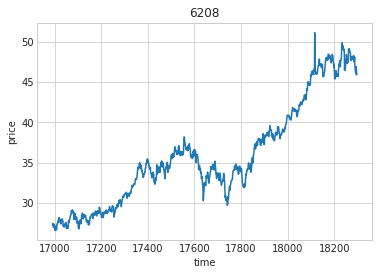

[[48.97 48.97 48.66 48.66  2.  ]
 [48.66 48.66 48.66 48.66  0.  ]
 [47.78 47.78 47.7  47.7   6.  ]
 [47.63 47.76 47.59 47.68 44.  ]
 [48.12 48.37 48.12 48.17  6.  ]
 [47.88 47.88 47.88 47.88  1.  ]
 [47.88 47.88 47.77 47.77  5.  ]
 [48.14 48.14 48.14 48.14  1.  ]
 [48.14 48.14 48.14 48.14  0.  ]
 [48.05 48.05 47.98 47.98  6.  ]
 [47.8  47.8  47.8  47.8   1.  ]
 [47.8  48.04 47.79 48.04 65.  ]
 [48.04 48.09 48.04 48.09  2.  ]
 [48.22 48.22 48.22 48.22  4.  ]
 [48.22 48.22 48.22 48.22  0.  ]
 [48.29 48.29 48.29 48.29  1.  ]
 [48.22 48.27 48.06 48.27 58.  ]
 [47.9  47.9  47.22 47.49 17.  ]
 [47.52 47.52 47.52 47.52  2.  ]
 [47.59 48.11 47.59 48.11  5.  ]
 [47.17 47.19 47.17 47.17 10.  ]
 [46.86 46.91 46.55 46.7  16.  ]
 [46.7  46.7  46.34 46.5  14.  ]
 [46.22 46.36 46.1  46.36  7.  ]
 [46.36 46.36 46.09 46.09 59.  ]
 [46.15 46.15 45.9  46.    6.  ]
 [46.88 46.9  46.88 46.9   2.  ]
 [46.5  46.5  46.48 46.48  3.  ]
 [45.98 45.98 45.98 45.98  1.  ]
 [45.9  46.13 45.9  45.9   4.  ]]


In [5]:
X_pred_18 = []
for code in codes:
    row = train_csv.loc[train_csv['代碼']==code][fields]
    print('Simple EDA on (code {:d})'.format(code))
    display(row.describe())
    fit, ax = plt.subplots()
    ax.set_title(str(code))
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    ax.plot(row['收盤價(元)'])
    plt.show()
    latest_30 = np.array(row)[-30:]
    print(latest_30)
    X_pred_18.append(latest_30)

In [ ]:
from keras.callbacks import *
from sklearn.model_selection import train_test_split
BATCH_SIZE = 64
EPOCH = 500
header = ['ETFid', 'Mon_ud', 'Mon_cprice', 'Tue_ud', 'Tue_cprice', 'Wed_ud', 'Wed_cprice', 'Thu_ud', 'Thu_cprice', 'Fri_ud', 'Fri_cprice']

with open('prediction.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, delimiter=',')
    wr.writerow(header)

for model_n, X_pred in enumerate(X_pred_18):
    prefix = str(codes[model_n])
    model = keras.models.load_model(prefix+"_model.h5", custom_objects={'r2_keras':keras.metrics.mean_absolute_error})
    Y_pred = model.predict(X_pred[np.newaxis,...])[0]
    Y_processed = ['00' + prefix]
    origin = X_pred[-1][3]
    print(f'{prefix}: {origin}')
    for i, x in enumerate(Y_pred[...,0]):
        if x - origin > 0:
            Y_processed.append(1)
        else:
            Y_processed.append(-1)
        Y_processed.append(x)
        origin = x
    with open('prediction.csv', 'a') as csvfile:
        wr = csv.writer(csvfile, delimiter=',')
        wr.writerow(Y_processed)
    K.clear_session()

![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
